```{code-cell} ipython3
:tags: ["hide-cell"]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries, concatenate
from darts.utils.utils import ModelMode
from darts.utils.callbacks import TFMProgressBar
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, stationarity_test_adf, stationarity_tests, extract_trend_and_seasonality
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler, Diff
from darts.models import *

plt.rcParams['figure.figsize'] = (12, 4)
rng = np.random.default_rng(42)
t = np.arange(1, 1000)
df = pd.DataFrame({
    'yearly_seasonality': np.sin(2*np.pi*t / 365),
    'weekly_seasonality': 0.25*np.sin(2*np.pi*t / 365*52),
    'trend': 1+t*.005,
    'noise': rng.normal(scale=0.15, size=len(t)),
},
    index=pd.date_range(start='2000-01-01', periods=len(t), freq='D')
)
df['total'] = df['yearly_seasonality'] + df['weekly_seasonality'] + df['trend'] + df['noise']

plt.plot(df['total'], label='Total (sum of all)')
plt.plot(df['yearly_seasonality'], label='Yearly Seasonality')
plt.plot(df['weekly_seasonality'], label='Weekly Seasonality')
plt.plot(df['trend'], label='Trend')
plt.plot(df['noise'], label='Noise', alpha=.5)
plt.legend()
plt.show()

# Convert dataframe to time series
series = TimeSeries.from_dataframe(df)

# Define the hierarchy to the data  (total = yearly_seasonality + weekly_seasonality + trend + noise)
series = series.with_hierarchy({
    'yearly_seasonality': ['total'],
    'weekly_seasonality': ['total'],
    'trend': ['total'],
    'noise': ['total'],
 })

# Split data
train, test = series.split_after(0.75)
```

In [1]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from darts import TimeSeries, concatenate
# from darts.utils.utils import ModelMode
# from darts.utils.callbacks import TFMProgressBar
# from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, stationarity_test_adf, stationarity_tests, extract_trend_and_seasonality
# from darts.metrics import mape, smape, mae
# from darts.dataprocessing.transformers import Scaler, Diff
# from darts.models import *

# plt.rcParams['figure.figsize'] = (12, 4)
# rng = np.random.default_rng(42)
# t = np.arange(1, 1000)
# df = pd.DataFrame({
#     'yearly_seasonality': np.sin(2*np.pi*t / 365),
#     'weekly_seasonality': 0.25*np.sin(2*np.pi*t / 365*52),
#     'trend': 1+t*.005,
#     'noise': rng.normal(scale=0.15, size=len(t)),
# },
#     index=pd.date_range(start='2000-01-01', periods=len(t), freq='D')
# )
# df['total'] = df['yearly_seasonality'] + df['weekly_seasonality'] + df['trend'] + df['noise']

# plt.plot(df['total'], label='Total (sum of all)')
# plt.plot(df['yearly_seasonality'], label='Yearly Seasonality')
# plt.plot(df['weekly_seasonality'], label='Weekly Seasonality')
# plt.plot(df['trend'], label='Trend')
# plt.plot(df['noise'], label='Noise', alpha=.5)
# plt.legend()
# plt.show()

# # Convert dataframe to time series
# series = TimeSeries.from_dataframe(df)

# # Define the hierarchy to the data  (total = yearly_seasonality + weekly_seasonality + trend + noise)
# series = series.with_hierarchy({
#     'yearly_seasonality': ['total'],
#     'weekly_seasonality': ['total'],
#     'trend': ['total'],
#     'noise': ['total'],
#  })

# # Split data
# train, test = series.split_after(0.75)

## Stationary
A time series is stationary if it does not exhibit any long term trends or obvious seasonality. It must have:
- constant variance through time
- constant mean through time

Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and so eliminating trends. This can also remove seasonality, if differences are taken appropriately (e.g. differencing observations 1 year apart to remove a yearly trend).

### Augmented Dickey-Fuller
We can use the Augmented Dickey-Fuller (ADF) test to test if the data is stationary. A p-value below 0.05 and a test statistic less than the critical value at the 5% significance level, indicates that the data is stationary at the 5% significance level.

In [2]:
def print_adf_results(adf_test):
    test_statistic, p_value, used_lag, nobs, critical_values, icbest = adf_test
    print(f"Test Statistic: {test_statistic:.4f}")
    print(f"P-Value: {p_value:.4f}")
    print(f"Number of Lags Used: {used_lag}")
    # print(f"Number of Observations: {nobs}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"    {key}: {value:.4f}")
    print(f"Maximized Information Criterion: {icbest:.4f}")
    
    

print_adf_results(stationarity_test_adf(train[['total']], maxlag=365))
print('\nWith differencing:')
print_adf_results(stationarity_test_adf(train[['total']].diff(), maxlag=365))
print('\nWith log-transform and differencing:')
print_adf_results(stationarity_test_adf(train[['total']].map(np.log).diff(), maxlag=365))

NameError: name 'stationarity_test_adf' is not defined

In [15]:
# Double test on stationarity using both Kwiatkowski-Phillips-Schmidt-Shin and Augmented Dickey-Fuller statistical tests.
stationarity_tests(train[['total']])

c:\Users\JBarker\OneDrive - Generac Power Systems, Inc\Documents\Code\torch\Lib\site-packages\darts\utils\statistics.py:462: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


False

### ACF (Autocorrelation Function) 
ACF measures the correlation between the time series and its lagged values. 

ACF is useful for identifying **MA (Moving Average)** components in time series models. If the ACF cuts off after a certain lag (e.g., drops to zero), it suggests that the series can be modeled by an MA process up to that lag.

Docs: [plot_acf](https://unit8co.github.io/darts/generated_api/darts.utils.statistics.html?highlight=plot_acf#darts.utils.statistics.plot_acf)

### PACF (Partial Autocorrelation Function)
PACF measures the correlation between the time series and its lagged values, **but removes the influence of intermediate lags**.

It provides the pure or "partial" correlation at each lag, controlling for the effects of previous lags.

PACF is useful for identifying **AR (Autoregressive)** components. A cut-off in the PACF indicates the order of the AR model to use (i.e., how many past terms are needed to explain the current observation).

There is seasonality of order 28.
There is seasonality of order 35.
There is seasonality of order 42.
There is seasonality of order 49.
There is seasonality of order 56.
There is seasonality of order 63.
There is seasonality of order 70.
There is seasonality of order 77.
There is seasonality of order 84.
There is seasonality of order 91.
There is seasonality of order 98.
There is seasonality of order 105.
There is seasonality of order 112.
There is seasonality of order 119.
There is seasonality of order 126.
There is seasonality of order 133.
There is seasonality of order 140.
There is seasonality of order 147.


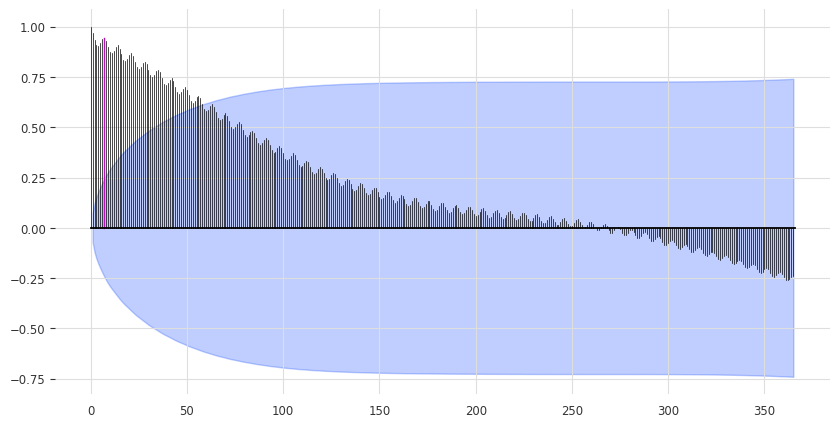

In [16]:
'''
- m: a time lag to highlight on the plot.
- max_lag: maximal lag order to consider.
- alpha: confidence interval to display.
'''
plot_acf(train[['total']], m=7, max_lag=365, alpha=0.05)

for m in range(25, 150):
    is_seasonal, period = check_seasonality(train[['total']], m=m, max_lag=365, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

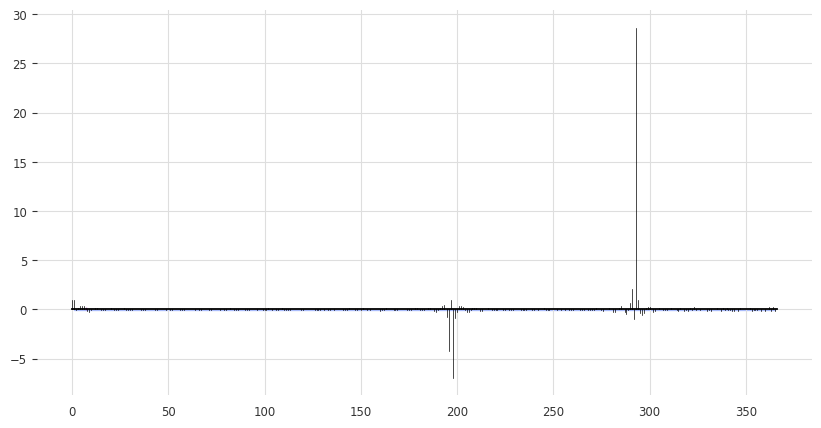

In [17]:
# plot_pacf(train[['total']], m=126, max_lag=150, alpha=0.05)
plot_pacf(train[['total']], m=7, max_lag=365, alpha=0.05)

In [18]:
# series
# scaler_covariates = Scaler()

### Extract trend and seasonality

In additive seasonality, the seasonal variation is added to the underlying trend, resulting in constant seasonal changes regardless of the overall level.

In multiplicative seasonality, the seasonal component is multiplied by the trend, leading to changes in the size of the seasonal pattern as the trend increases or decreases.

STL: Season-Trend decomposition using LOESS

MSTL: Season-Trend decomposition using LOESS with multiple seasonalities

<Axes: xlabel='time'>

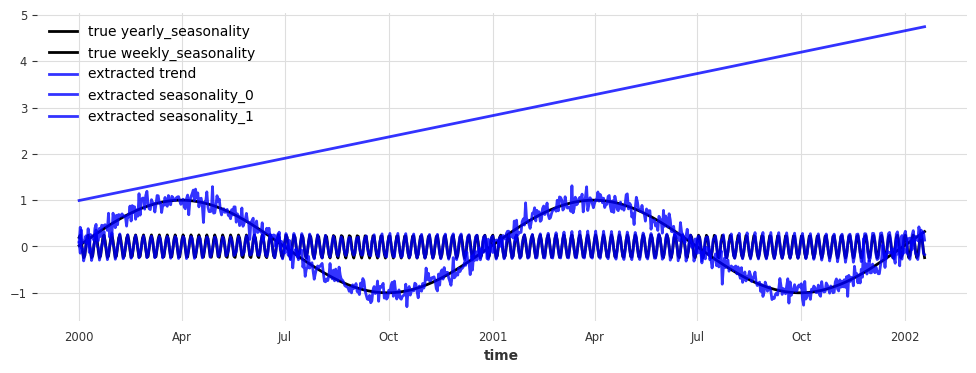

In [169]:
train[['yearly_seasonality']].plot(label='true yearly_seasonality', color='black')
train[['weekly_seasonality']].plot(label='true weekly_seasonality', color='black')

trend, seasonality = extract_trend_and_seasonality((train[['total']]), freq=[7, 365], model=ModelMode.ADDITIVE, method='MSTL')
trend.plot(label='extracted trend', color='blue', alpha=.8)
seasonality.plot(label='extracted seasonality', color='blue', alpha=.8)

<Axes: xlabel='time'>

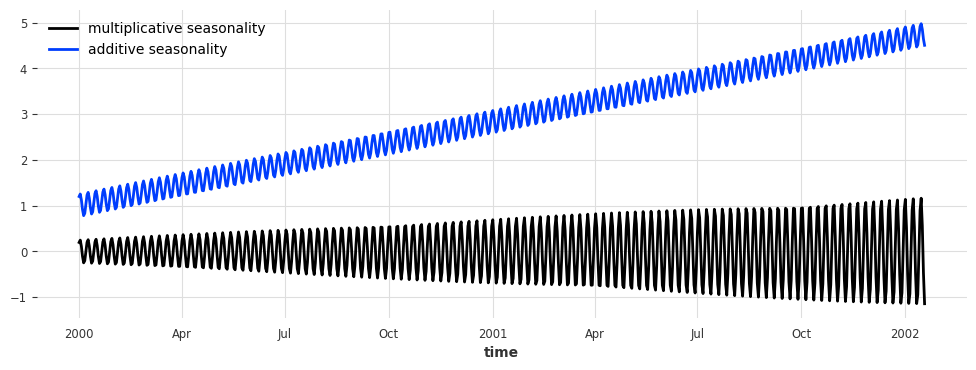

In [174]:
(train[['weekly_seasonality']] * train[['trend']]).plot(label='multiplicative seasonality')
(train[['weekly_seasonality']] + train[['trend']]).plot(label='additive seasonality')

### Naive Forecast
- NaiveSeasonal(K) "repeats" the value that occured 'K' time steps ago.
- NaiveDrift produces linear predictions, with a slope that is determined by the first and last values of the training set.

<Axes: xlabel='time'>

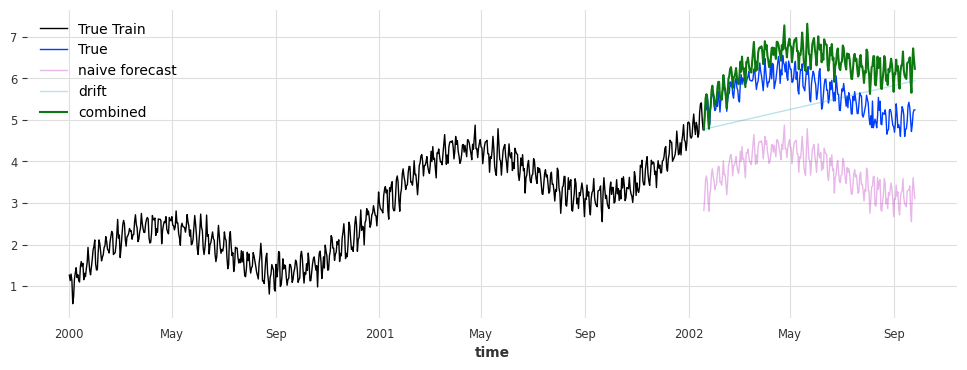

In [209]:
seasonal_model = NaiveSeasonal(K=365)
seasonal_model.fit(train[['total']])
seasonal_forecast = seasonal_model.predict(len(test))

drift_model = NaiveDrift()
drift_model.fit(train[['total']])
drift_forecast = drift_model.predict(len(test))

combined_forecast = drift_forecast + seasonal_forecast - seasonal_forecast[['total']].first_value()

train[['total']].plot(label='True Train', linewidth=1)
test[['total']].plot(label='True', linewidth=1, alpha=1)

seasonal_forecast.plot(label="naive forecast", linewidth=1, alpha=0.3)
drift_forecast.plot(label="drift", linewidth=1, alpha=0.3)
combined_forecast.plot(label="combined", linewidth=1.5)

### Exponential Smoothing

In [40]:
def fit_predict_plot(model, model_name):
    model.fit(train[['total']])
    pred = model.predict(len(test))
    train[['total']].plot(label='Train', linewidth=1)
    test[['total']].plot(label='Test', linewidth=1, alpha=0.6)
    pred.plot(label=f'{model_name}', alpha=0.8)
    plt.show()
    print(f"{model_name} MAPE: {mape(test[['total']], pred):.2f}%.)")

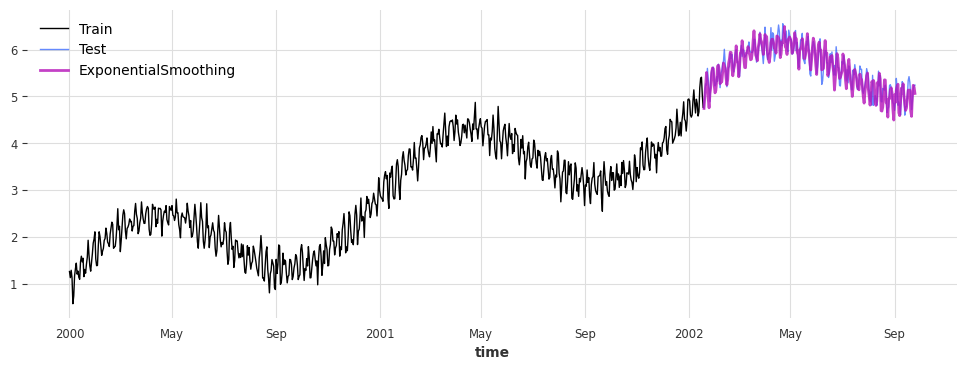

ExponentialSmoothing MAPE: 2.71%.)


In [41]:
fit_predict_plot(ExponentialSmoothing(seasonal_periods=365), model_name='ExponentialSmoothing')
# fit_predict_plot(StatsForecastAutoETS(season_length=365), model_name='StatsForecastAutoETS')

### ARIMA
[ARIMA docs](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.arima.html#darts.models.forecasting.arima.ARIMA)


c:\Users\JBarker\OneDrive - Generac Power Systems, Inc\Documents\Code\torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\JBarker\OneDrive - Generac Power Systems, Inc\Documents\Code\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


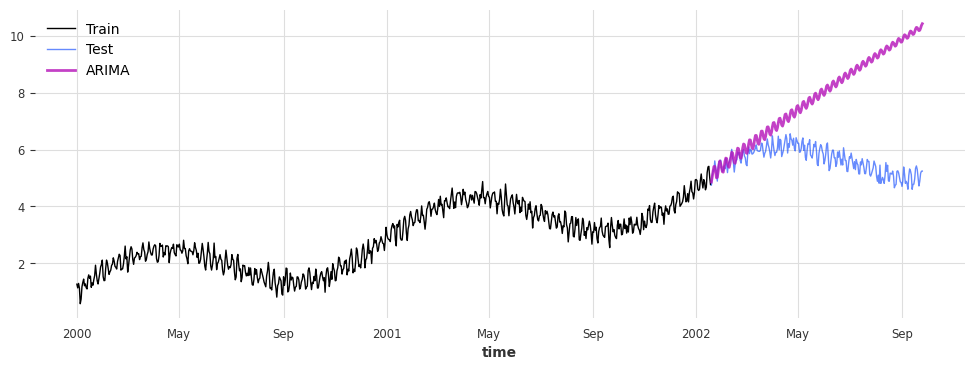

ARIMA MAPE: 41.69%.)


In [47]:
fit_predict_plot(ARIMA(p=30, d=1, q=7), model_name='ARIMA')

c:\Users\JBarker\OneDrive - Generac Power Systems, Inc\Documents\Code\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


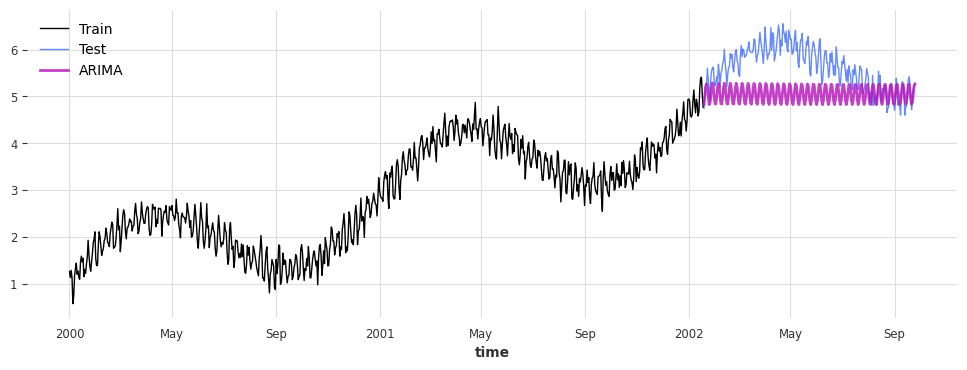

ARIMA MAPE: 10.12%.)


In [43]:
fit_predict_plot(ARIMA(p=7, d=1, q=7), model_name='ARIMA')
# fit_predict_plot(AutoARIMA(), model_name='AutoARIMA')
# fit_predict_plot(StatsForecastAutoARIMA(), model_name='StatsForecastAutoARIMA ')

c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


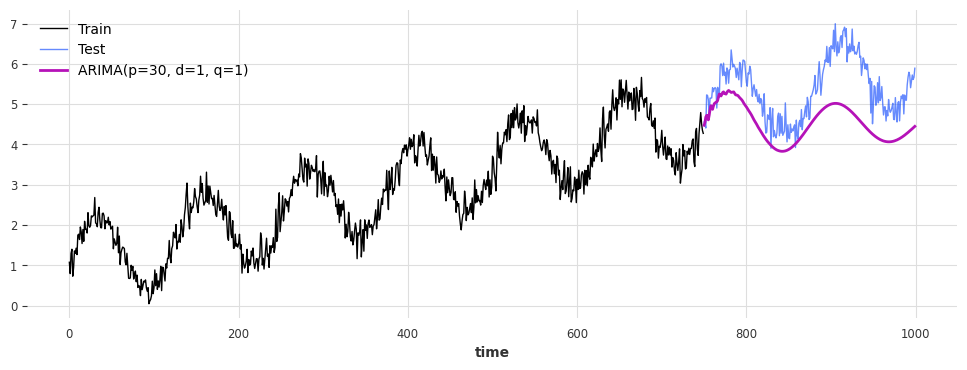

ARIMA(p=30, d=1, q=1) MAPE: 15.23%.)


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


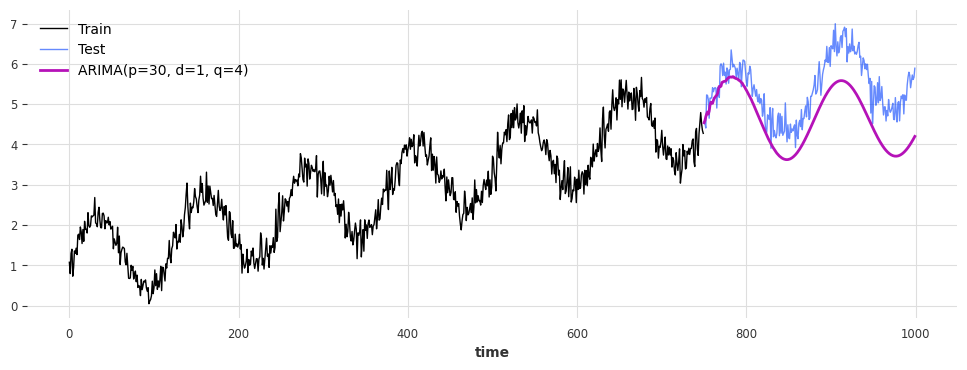

ARIMA(p=30, d=1, q=4) MAPE: 13.77%.)


In [21]:
fit_predict_plot(ARIMA(p=30, d=1, q=1), model_name='ARIMA(p=30, d=1, q=1)')
fit_predict_plot(ARIMA(p=30, d=1, q=4), model_name='ARIMA(p=30, d=1, q=4)')

c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


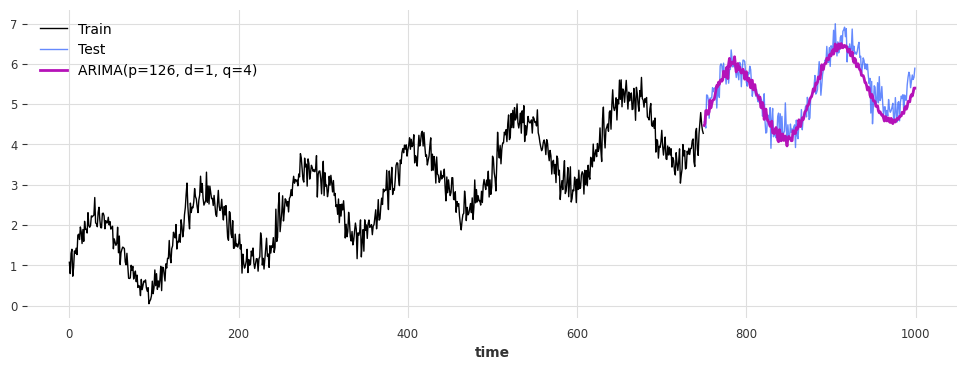

ARIMA(p=126, d=1, q=4) MAPE: 4.76%.)


In [22]:
fit_predict_plot(ARIMA(p=126, d=1, q=4), model_name='ARIMA(p=126, d=1, q=4)')

<!-- 
There is seasonality of order 28.
There is seasonality of order 35.
There is seasonality of order 42.
There is seasonality of order 49.
There is seasonality of order 56.
There is seasonality of order 63.
There is seasonality of order 70.
There is seasonality of order 77.
There is seasonality of order 84.
There is seasonality of order 91.
There is seasonality of order 98.
There is seasonality of order 105.
There is seasonality of order 112.
There is seasonality of order 119.
There is seasonality of order 126.
There is seasonality of order 133.
There is seasonality of order 140.
There is seasonality of order 147. -->


In [12]:
fit_predict_plot(ARIMA(p=28, d=1, q=1), model_name='ARIMA(p=28, d=1, q=1)')

NameError: name 'fit_predict_plot' is not defined

c:\Users\JBarker\OneDrive - Generac Power Systems, Inc\Documents\Code\torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\JBarker\OneDrive - Generac Power Systems, Inc\Documents\Code\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


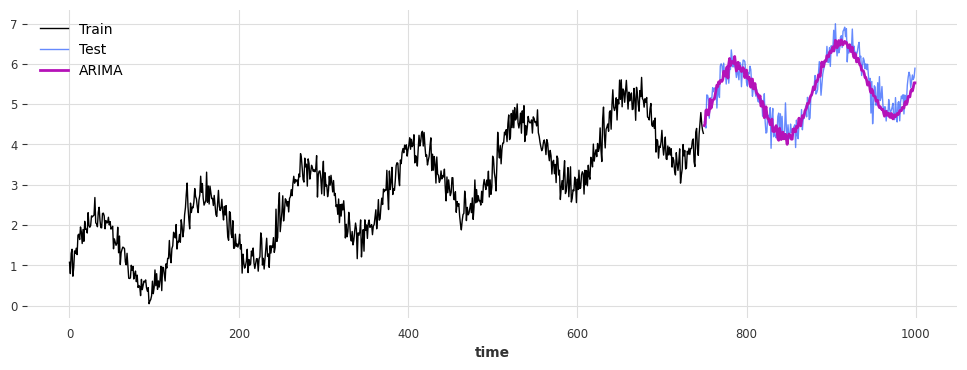

ARIMA MAPE: 4.27%.)


In [241]:
fit_predict_plot(ARIMA(p=126, d=1, q=1), model_name='ARIMA(p=126, d=1, q=1)')

### Fast Fourier Transform

In [ ]:
model = FFT(nr_freqs_to_keep=200, trend='poly', trend_poly_degree=2)
model.fit(train[['total']])
pred = model.predict(len(test))

train['total'].plot(label='train')
test['total'].plot(label='test')
pred.plot(label='FFT')

### Hierarchical time series 
[Textbook example](https://otexts.com/fpp3/hts.html#hierarchical-time-series)

In [ ]:
# # Convert dataframe to time series
# series = TimeSeries.from_dataframe(df)

# # Define the hierarchy to the data  (total = yearly_seasonality + weekly_seasonality + trend + noise)
# series = series.with_hierarchy({
#     'yearly_seasonality': ['total'],
#     'weekly_seasonality': ['total'],
#     'trend': ['total'],
#     'noise': ['total'],
#  })

# # Split data
# train, test = series.split_after(0.75)

In [ ]:
# df2 = pd.DataFrame({
#     'seasonality': 1 + np.cos(np.arange(data_size)*.05),
#     'trend': np.arange(data_size)**.25,
#     'noise': rng.lognormal(mean=0., sigma=.25, size=data_size),
# })
# df2['total'] = df2['seasonality'] + df2['trend'] + df2['noise']
# plt.plot(df2['seasonality'], label='Seasonality')
# plt.plot(df2['trend'], label='Trend')
# plt.plot(df2['noise'], label='Noise')
# plt.plot(df2['total'], label='Total (sum of all)')
# plt.legend()
# plt.show()

https://www.fb.org/market-intel/u-s-agricultural-land-values-and-cropland-cash-rents-reach-record-levels-amid-falling-commodity-prices#:~:text=This%20increase%20came%20in%20as,value%20between%202019%20and%202020.

"Increases in land values and rents result from rising expectations of higher long-term (nominal) operating profits; and while those increases benefit landowners by enhancing their equity and their rental returns, it also puts farmers on a treadmill, forcing them to cover ever-rising costs for purchased or rented land. Record rental rates are a significant problem for those reliant on renting land and new or beginning farmers. High rental rates and land costs strain their financial viability, particularly when input costs are already high and rising and commodity prices are dropping."

https://www.ers.usda.gov/topics/farm-economy/land-use-land-value-tenure/farmland-value/

In [53]:
import requests
import re

def parse_farm_real_estate_data(html_text):
    nominal_data = []
    inflation_adjusted_data = []

    # Regular expression patterns to extract data points
    nominal_pattern = re.compile(r'Line 1, Nominal\.<br />(.*?)Line 2', re.DOTALL)
    inflation_pattern = re.compile(r'Line 2, Inflation adjusted \(2023=100\)\.<br />(.*)', re.DOTALL)
    
    # Extracting nominal and inflation-adjusted data block
    nominal_block = re.search(nominal_pattern, html_text)
    inflation_block = re.search(inflation_pattern, html_text)

    # Extract points from each block
    if nominal_block:
        nominal_points = re.findall(r'Point \d+, (\d{4}) is (\d+)', nominal_block.group(1))
        nominal_data = [(int(year), int(value)) for year, value in nominal_points]

    if inflation_block:
        inflation_points = re.findall(r'Point \d+, (\d{4}) is (\d+)', inflation_block.group(1))
        inflation_adjusted_data = [(int(year), int(value)) for year, value in inflation_points]

    df = pd.DataFrame({
        'date': [point[0] for point in nominal_data],
        'nominal_value': [point[1] for point in nominal_data],
        'inflation_adjusted_value': [point[1] for point in inflation_adjusted_data]
    })

    return df


url = "https://www.ers.usda.gov/webdocs/charts/55910/farmrealestatevalue19502023_d.html?v=7604.9"
response = requests.get(url, verify=False)

# Checking if the request was successful
if response.status_code == 200:
    farm_real_estate_df = parse_farm_real_estate_data(response.text)
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")

farm_real_estate_df

c:\Users\JBarker\OneDrive - Generac Power Systems, Inc\Documents\Code\torch\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ers.usda.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,date,nominal_value,inflation_adjusted_value
0,1950,65,651
1,1951,74,695
2,1952,82,753
3,1953,83,753
4,1954,82,736
...,...,...,...
69,2019,3160,3705
70,2020,3160,3656
71,2021,3380,3739
72,2022,3800,3927


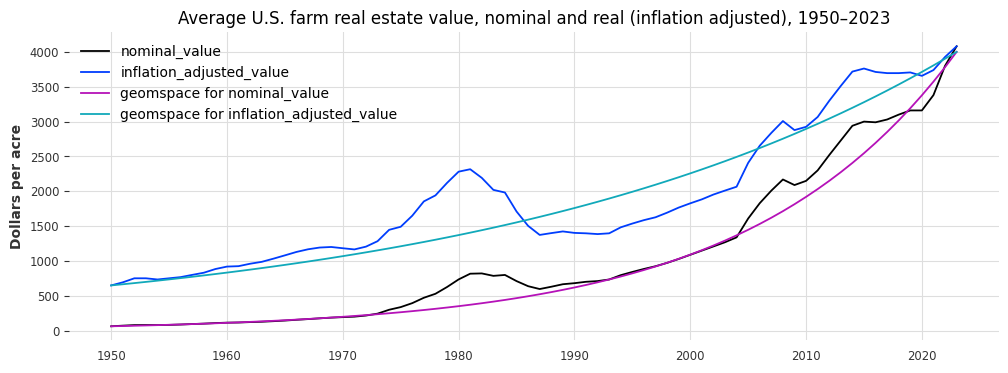

In [74]:
plt.plot(farm_real_estate_df.date, farm_real_estate_df.nominal_value, label='nominal_value')
plt.plot(farm_real_estate_df.date, farm_real_estate_df.inflation_adjusted_value, label='inflation_adjusted_value')
plt.plot(farm_real_estate_df.date, np.geomspace(farm_real_estate_df.nominal_value[0], 4000, num=len(farm_real_estate_df)), label='geomspace for nominal_value')
plt.plot(farm_real_estate_df.date, np.geomspace(farm_real_estate_df.inflation_adjusted_value[0], 4000, num=len(farm_real_estate_df)), label='geomspace for inflation_adjusted_value')
plt.title("Average U.S. farm real estate value, nominal and real (inflation adjusted), 1950–2023")
plt.ylabel('Dollars per acre')
plt.legend()

In [71]:
farm_real_estate_df.date, , label='nominal_value')
plt.plot(farm_real_estate_df.date, farm_real_estate_df.inflation_adjusted_value, label='inflation_adjusted_value')
plt.plot(farm_real_estate_df.date, , label='geomspace for nominal_value')

65

In [76]:
geomspace_nominal_values = np.geomspace(farm_real_estate_df.nominal_value.iloc[0], farm_real_estate_df.nominal_value.iloc[-1], num=len(farm_real_estate_df))

area_above = np.trapz(np.maximum(farm_real_estate_df.nominal_value - geomspace_nominal_values, 0), farm_real_estate_df.date)
area_below = np.trapz(np.maximum(geomspace_nominal_values - farm_real_estate_df.nominal_value, 0), farm_real_estate_df.date)

area_above, area_below

(7563.308926221813, 957.8241471109584)